In [1]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import os
import sys
import inspect

# code to manage where are lunch the file
if str(os.getcwd()).split("/")[-1] == "notebooks":
    sys.path.insert(1, os.path.realpath(os.path.pardir))
    path_b = "../"
else:
    path_b ='./'
import config as c

In [2]:
windows = c.windows
number_crypto = c.number_cryptos
market_cap = c.market_cap

df_name_index = pd.read_csv(f"{path_b}data/processed/first_{number_crypto}_crypto_list.csv", index_col=0)
df = pd.read_csv(f"{path_b}data/processed/market_cap_crypto.csv", index_col=0)

df_close_price = pd.read_csv(f'{path_b}data/processed/close_price_crypto.csv', index_col=0)
df_close_price['date'] = pd.to_datetime(df_close_price.index)
df_close_price['date'] = df_close_price['date'].dt.date
df_close_price.index = df_close_price['date']
del df_close_price['date']

# processing part Data

In [3]:
## use market cap file

df_market_cap = pd.read_csv(f'{path_b}data/processed/crypto_date_marketcap_1mio_sorted.csv', index_col=0)
df_market_cap = df_market_cap[df_market_cap.index != 95]

df_market_cap_first_20 = df_market_cap.iloc[:number_crypto]

#select last date
first_date = df_market_cap_first_20['first_date_marketcap_1mio'].tail(1).values

first_date_final = pd.to_datetime(first_date[0])

# TODO: change way to do it in the index
df_final_data = df_close_price.drop(df_close_price[df_close_price.index < first_date_final].index)
df_final_data = df_final_data[df_market_cap_first_20['crypto_name']]
df_final_data_return = df_final_data.pct_change().iloc[1:,:].fillna(0)
df_final_data_return

/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,bitcoin,litecoin,ripple,nxt,dogecoin,digibyte,dash,monero,bitshares,stellar,verge,nem,ethereum,siacoin,decred,lisk,digixdao,steem,waves,ardor
date,,,,,,,,,,,,,,,,,,,,
2016-07-24,0.008739,0.003369,-0.004941,-0.081716,-0.006619,-0.072385,-0.010791,-0.004509,0.003641,0.080923,0.011373,-0.047804,-0.108408,-0.044460,-0.028217,-0.078884,-0.083765,-0.075400,0.003529,0.147018
2016-07-25,-0.010870,-0.009490,-0.006238,0.035876,-0.014273,0.056726,-0.007864,-0.018942,-0.052185,-0.048709,-0.013082,0.018683,0.085227,-0.010072,0.089398,0.017741,0.049741,-0.054936,-0.000856,-0.006794
2016-07-26,-0.003536,-0.015327,-0.039812,-0.078644,-0.023187,-0.034207,-0.029828,-0.010643,-0.041139,-0.095281,-0.015058,-0.060420,-0.133462,-0.018908,-0.066011,-0.020853,-0.020025,-0.151563,-0.141359,-1.000000
2016-07-27,0.003940,-0.003614,-0.004770,0.004167,-0.011650,-0.099027,0.033073,0.064287,-0.002082,-0.003997,0.017589,0.008823,0.082013,-0.002448,-0.012547,-0.031271,-0.002191,-0.012264,0.050092,0.000000
2016-07-28,0.001044,0.002996,0.000772,0.001902,0.004406,0.038619,0.016842,-0.046045,0.020667,0.008678,-0.001818,-0.002494,-0.009959,0.015383,0.005612,0.008792,0.030216,-0.035072,-0.032438,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-13,0.024269,0.027955,0.024080,-0.013235,0.027978,0.012159,0.015025,-0.007989,0.054732,0.103626,0.018437,0.017043,0.032534,0.045729,-0.011512,0.034408,0.035003,0.080198,0.073210,0.039583
2021-10-14,-0.001386,0.014018,0.003477,0.029762,-0.001287,0.004293,0.014698,-0.030941,0.051736,0.004524,0.036034,0.010034,0.049862,0.006881,-0.010868,0.033002,0.050502,0.024954,0.012698,0.005619
2021-10-15,0.074534,0.048278,0.007272,0.025513,0.006497,0.023845,0.039352,0.027274,0.021025,-0.021369,0.031137,-0.028193,0.020238,-0.022227,-0.020010,0.026891,0.022883,-0.077504,-0.067306,-0.068447


In [4]:
#Long Asset with Low Vol
df_vol = df_final_data_return.rolling(windows).std().dropna()
returns_vol_quantile = df_vol.T.apply(lambda x: pd.qcut(x, 5, labels=False, duplicates="drop"), axis=0).T

In [5]:
for i in returns_vol_quantile.columns:
    returns_vol_quantile.loc[returns_vol_quantile[i] == 0, i] = 0.5 # First quantile for vol
    returns_vol_quantile.loc[returns_vol_quantile[i] == 1, i] = 0
    returns_vol_quantile.loc[returns_vol_quantile[i] == 2, i] = 0
    returns_vol_quantile.loc[returns_vol_quantile[i] == 3, i] = 0
    returns_vol_quantile.loc[returns_vol_quantile[i] == 4, i] = -0.5

## Low Vol part ##
returns_low_vol_quantile = returns_vol_quantile.replace(0.5,1)
returns_low_vol_quantile = returns_low_vol_quantile.replace(-0.5,0)
returns_low_vol_quantile['sum'] = returns_low_vol_quantile.sum(axis=1)

#better to do things => here Low Vol portfolio
# Do the same things about High vol
for i in tqdm(returns_low_vol_quantile.index):
    number = returns_low_vol_quantile['sum'].loc[i]
    for column in returns_low_vol_quantile.columns:
        returns_low_vol_quantile[column].loc[i] = returns_low_vol_quantile[column].loc[i] / number
del returns_low_vol_quantile['sum']

## High Vol part ##

returns_high_vol_quantile = returns_vol_quantile.replace(-0.5,1)
returns_high_vol_quantile = returns_high_vol_quantile.replace(0.5,0)
returns_high_vol_quantile['sum'] = returns_high_vol_quantile.sum(axis=1)

#better to do things => here Low Vol portfolio
# Do the same things about High vol
for i in tqdm(returns_high_vol_quantile.index):
    number = returns_high_vol_quantile['sum'].loc[i]
    for column in returns_high_vol_quantile.columns:
        returns_high_vol_quantile[column].loc[i] = returns_high_vol_quantile[column].loc[i] / number
del returns_high_vol_quantile['sum']

100%|██████████| 1591/1591 [00:11<00:00, 137.36it/s]


In [9]:
# TODO: debug return
pd.set_option('display.max_rows', 2000)
df_final_data_return = df_final_data_return.loc[returns_low_vol_quantile.index,:]
low_vol_return = np.multiply(df_final_data_return, returns_low_vol_quantile)
low_vol_perf = np.sum(low_vol_return,1)

high_vol_return = np.multiply(df_final_data_return, returns_high_vol_quantile)
high_vol_perf = np.sum(high_vol_return,1)

date
2017-02-10     100.930834
2017-02-11     102.489744
2017-02-12     101.400670
2017-02-13     100.416985
2017-02-14     101.843952
2017-02-15     101.700775
2017-02-16     101.667775
2017-02-17     102.351598
2017-02-18      98.636810
2017-02-19     101.365530
2017-02-20     101.967805
2017-02-21     101.754064
2017-02-22     100.731421
2017-02-23     102.910992
2017-02-24     102.840598
2017-02-25     101.013147
2017-02-26     101.272551
2017-02-27     101.932497
2017-02-28      99.482202
2017-03-01      99.053132
2017-03-02     103.753604
2017-03-03     106.152954
2017-03-04     103.722726
2017-03-05     103.791512
2017-03-06     105.167897
2017-03-07     106.371958
2017-03-08     104.554129
2017-03-09     105.221061
2017-03-10     100.966358
2017-03-11     103.800047
2017-03-12     108.002086
2017-03-13     113.452598
2017-03-14     114.366202
2017-03-15     115.629898
2017-03-16     114.147536
2017-03-17     108.155190
2017-03-18     106.527448
2017-03-19     110.987974
2017-03

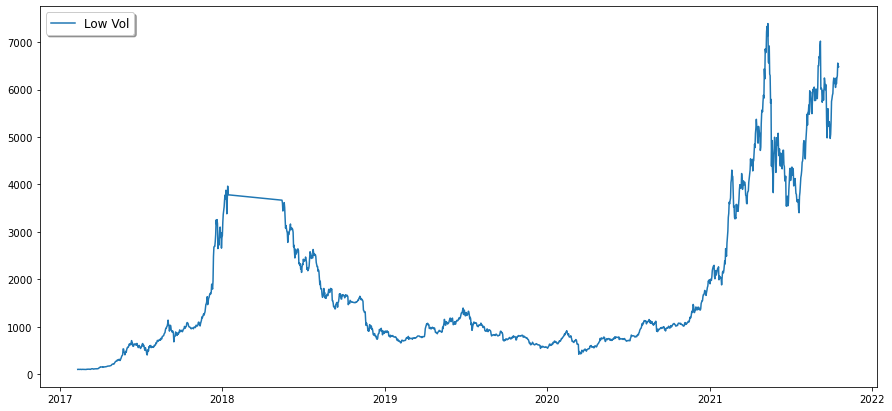

In [11]:
plt.figure(figsize=(15,7))
low_vol = (low_vol_perf+1).cumprod()*100
print(low_vol)

high_vol = (high_vol_perf+1).cumprod()*100

plt.plot(low_vol)
plt.legend(['Low Vol', 'High vol'],loc='upper left',fontsize='large',fancybox=True, shadow=True)
plt.show()

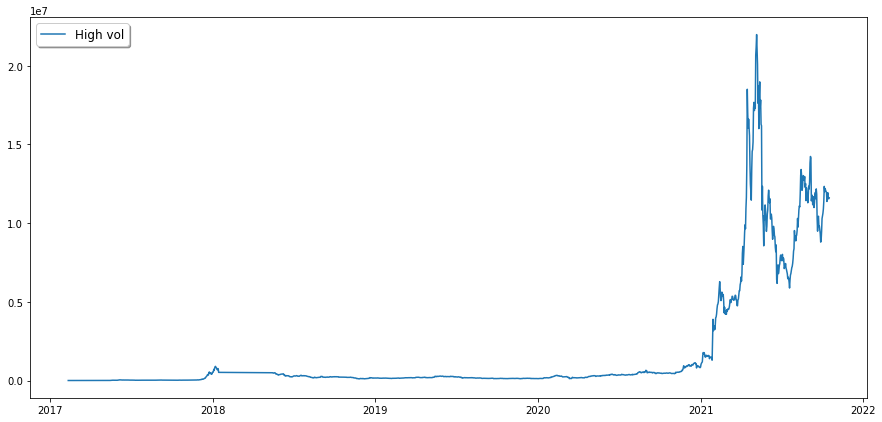

In [13]:
plt.figure(figsize=(15,7))
plt.plot(high_vol)
plt.legend(['High vol'],loc='upper left',fontsize='large',fancybox=True, shadow=True)
plt.show()